### Imports

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Deep Learning
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt

### Data Extraction and Feature Engineering

In [2]:
# Load data from saved file
df = pd.read_csv("data/pair_trade.csv")
df.drop(columns="Date", inplace=True)
df["lrets_a1"] = np.log(df["Asset1"] / df["Asset1"].shift(1))
df["lrets_a2"] = np.log(df["Asset2"] / df["Asset2"].shift(1))
df["lrets_a1_roll"] = df["lrets_a1"].rolling(window=21).mean()
df["lrets_a2_roll"] = df["lrets_a2"].rolling(window=21).mean()
df["a1_prod_rets"] = df["lrets_a1"].cumsum()
df["a2_prod_rets"] = df["lrets_a2"].cumsum()
df.dropna(inplace=True)
print("Length: ", len(df))
df.head(2)

Length:  1243


,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets
21,54.227489,53.271168,-2.055377,0.403727,-0.000543,0.000741,0.000527,0.000836,0.011074,0.017551
22,53.589405,52.501556,-1.880340,0.649103,-0.011837,-0.014552,-0.000028,0.000188,-0.000763,0.002998


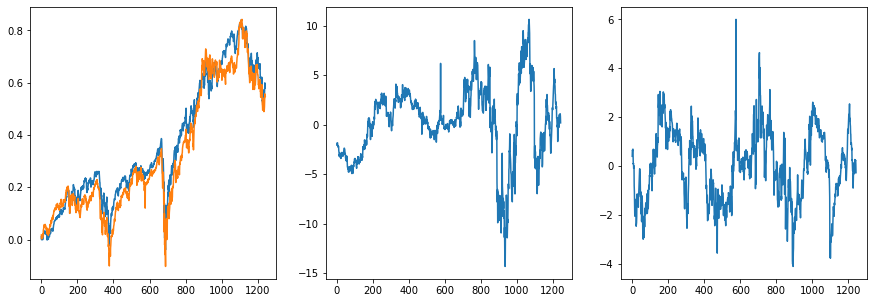

In [3]:
# Visualize Data
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(df["a1_prod_rets"].values)
plt.plot(df["a2_prod_rets"].values)

plt.subplot(1, 3, 2)
plt.plot(df["Spread"].values)

plt.subplot(1, 3, 3)
plt.plot(df["ZScore"].values)

In [4]:
# Add Target
future_step = 1
df["TARGET"] = 0
df.loc[df["Spread"].shift(-future_step) > 0, "TARGET"] = 1
df.dropna(inplace=True)
df.head(2)

,Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,TARGET
21,54.227489,53.271168,-2.055377,0.403727,-0.000543,0.000741,0.000527,0.000836,0.011074,0.017551,0
22,53.589405,52.501556,-1.880340,0.649103,-0.011837,-0.014552,-0.000028,0.000188,-0.000763,0.002998,0


In [5]:
# Split X and y
X_data = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
len(X_data), len(y)

(1243, 1243)

In [6]:
# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X_data)
X[:2]

array([[-1.26492611, -1.13504476, -0.63395987,  0.25890302, -0.06874343,
         0.0197518 ,  0.02761802,  0.13117419, -1.46674999, -1.28742802],
       [-1.29718371, -1.17576153, -0.58682679,  0.42967168, -0.84531675,
        -0.94004753, -0.15727973, -0.06985924, -1.51634206, -1.34812881]])

### Dataload Structuring

In [7]:
# Dataset Class
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
        self.length = self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def __len__(self):
        return self.length

trainset = dataset(X, y)
trainloader = DataLoader(trainset, batch_size=64, shuffle=False)

In [8]:
# Review X Data
trainloader.dataset.X[:2]

tensor([[-1.2649, -1.1350, -0.6340,  0.2589, -0.0687,  0.0198,  0.0276,  0.1312,
         -1.4668, -1.2874],
        [-1.2972, -1.1758, -0.5868,  0.4297, -0.8453, -0.9400, -0.1573, -0.0699,
         -1.5163, -1.3481]])

In [9]:
# Review y Data
trainloader.dataset.y[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Build Neural Net

In [10]:
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()   
        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

### Train Neural Net

In [11]:
# Hyperparams
learning_rate = 0.01
epochs = 1000

# Model, Optimizer, Loss
model = Net(input_shape=X.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

In [12]:
# Forward Loop
losses = []
accur = []
for i in range(epochs):
    for j, (X_train, y_train) in enumerate(trainloader):
        
        # Calculate ouput
        output = model(X_train)
        
        # Calculate loss
        loss = loss_fn(output, y_train.reshape(-1, 1))
        
        # Calculate accuracy
        predicted = model(torch.tensor(X, dtype=torch.float32))
        acc = (predicted.detach().numpy().round() == y).mean()
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print Results
        if i % 100 == 0:
            losses.append(loss)
            accur.append(acc)
            print(f"Epoch: {i}, Loss: {loss}, Accuracy: {acc}")

Epoch: 0, Loss: 0.6172119379043579, Accuracy: 0.40176525145804437
Epoch: 0, Loss: 0.4966989755630493, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 0.5728052258491516, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 1.0462737083435059, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 1.0695273876190186, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 1.0753693580627441, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 1.144491195678711, Accuracy: 0.4014481094127112
Epoch: 0, Loss: 0.9709247350692749, Accuracy: 0.40192382248071096
Epoch: 0, Loss: 0.5487481951713562, Accuracy: 0.4112795128180401
Epoch: 0, Loss: 0.6803386211395264, Accuracy: 0.4376023025806948
Epoch: 0, Loss: 0.6793113350868225, Accuracy: 0.47010936222734684
Epoch: 0, Loss: 0.5683256983757019, Accuracy: 0.49896928835266713
Epoch: 0, Loss: 0.5915720462799072, Accuracy: 0.5216449445939902
Epoch: 0, Loss: 0.6107026934623718, Accuracy: 0.5433691746993138
Epoch: 0, Loss: 0.6569744348526001, Accuracy: 0.5566891406033078
Epoch: 0, Loss: 0.6336

Epoch: 700, Loss: 0.0, Accuracy: 0.5181563820953251
Epoch: 700, Loss: 0.0, Accuracy: 0.5181563820953251
Epoch: 700, Loss: 0.03861154615879059, Accuracy: 0.5181563820953251
Epoch: 700, Loss: 0.04356854036450386, Accuracy: 0.5181563820953251
Epoch: 700, Loss: 0.006984235253185034, Accuracy: 0.5183149531179917
Epoch: 700, Loss: 0.0, Accuracy: 0.5181563820953251
Epoch: 700, Loss: 3.3527644660580336e-08, Accuracy: 0.5181563820953251
Epoch: 700, Loss: 0.021275006234645844, Accuracy: 0.5181563820953251
Epoch: 700, Loss: 0.013699924573302269, Accuracy: 0.5181563820953251
Epoch: 700, Loss: 0.011140805669128895, Accuracy: 0.5179978110726585
Epoch: 700, Loss: 0.08394324779510498, Accuracy: 0.5179978110726585
Epoch: 700, Loss: 1.3038520485508798e-08, Accuracy: 0.5179978110726585
Epoch: 700, Loss: 0.00048445630818605423, Accuracy: 0.5179978110726585
Epoch: 700, Loss: 0.04861688241362572, Accuracy: 0.5179978110726585
Epoch: 700, Loss: 5.824645540997153e-06, Accuracy: 0.5179978110726585
Epoch: 700, L